In [ ]:
# Importing libraries
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchvision import models
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!nvidia-smi

Thu Apr 27 09:00:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Normalize the image

In [ ]:
# Defining hyperparameters
batch_size = 32
num_epochs = 6
learning_rate = 0.0003

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training"
print("DATA_PATH = ",DATA_PATH)

DATA_PATH =  /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training


In [ ]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.80 * len(data)) 
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 2880 data points.
Train Dataset has 2304 data points
Test Dataset has 576 data points.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

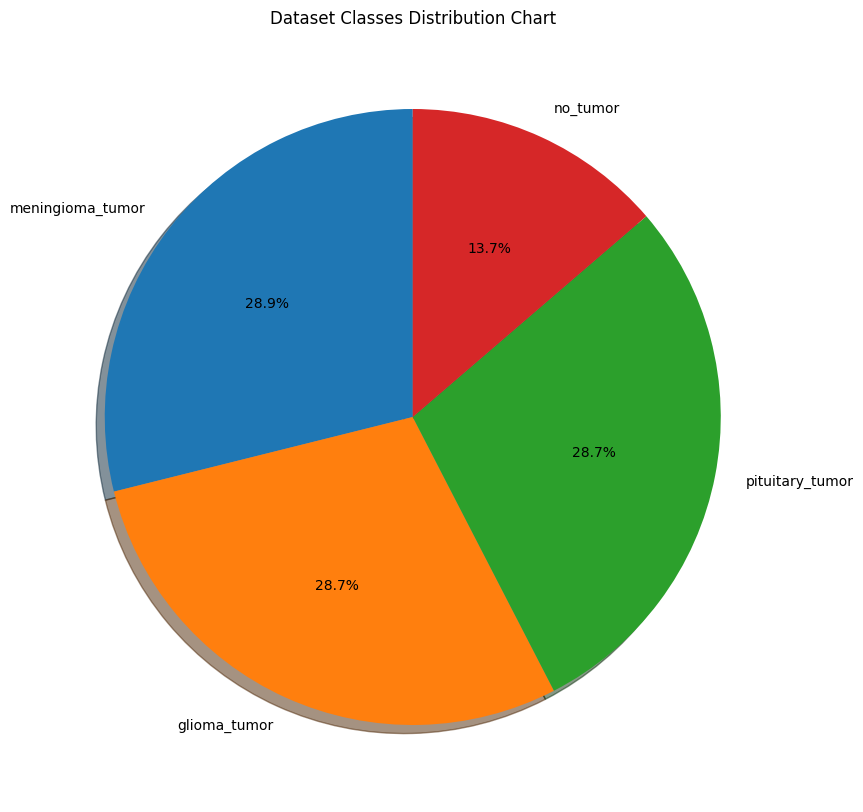

{'meningioma_tumor': 831, 'glioma_tumor': 825, 'pituitary_tumor': 826, 'no_tumor': 394}


In [ ]:


# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

In [ ]:
model = models.googlenet(pretrained= True)
for param in model.parameters():
    param.require_grad = True

fc = nn.Sequential(
    nn.Linear(1024,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 5)
)

model.classifier = fc

model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(param.require_grad), lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 90.6MB/s]


In [ ]:
total_step = len(train_loader)
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []

# Training 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        epoch_start_time = time.time()
        running_loss = 0.0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time



arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

# Prediction
with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the ' + str(len(test_dataset)) + ' test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/6], Step [71/72], Loss: 0.9171: Batch Loss : 0.012916209832043715
Epoch [2/6], Step [71/72], Loss: 0.1345: Batch Loss : 0.0018942905983454744
Epoch [3/6], Step [71/72], Loss: 0.0723: Batch Loss : 0.0010180065119770212
Epoch [4/6], Step [71/72], Loss: 0.0662: Batch Loss : 0.0009324057421214144
Epoch [5/6], Step [71/72], Loss: 0.0066: Batch Loss : 9.290519183580304e-05
Epoch [6/6], Step [71/72], Loss: 0.0340: Batch Loss : 0.00047888375923667157
Test Accuracy of the model on the 576 test images: 92.1875 %


In [ ]:


x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 960.8181805610657 sn


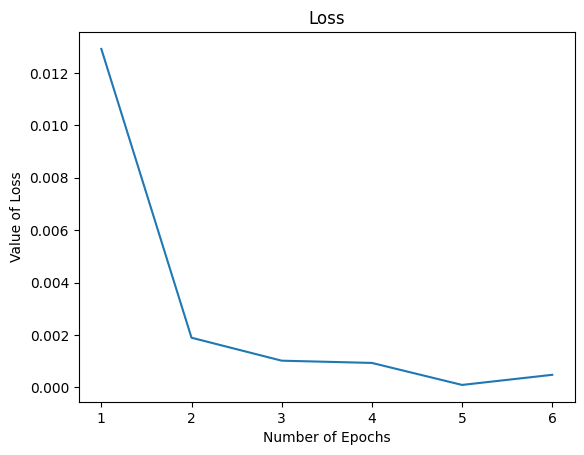

In [ ]:


import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

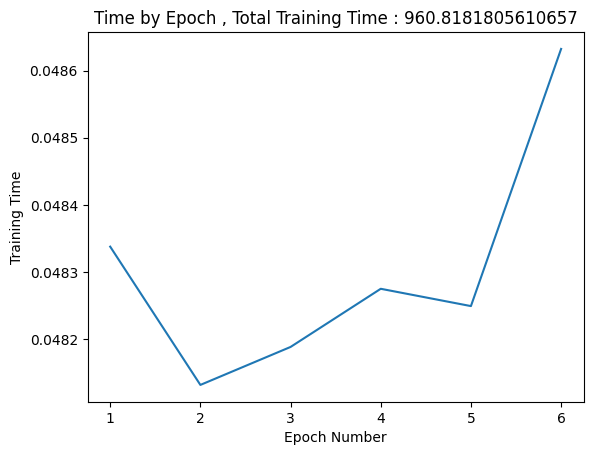

In [ ]:


plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

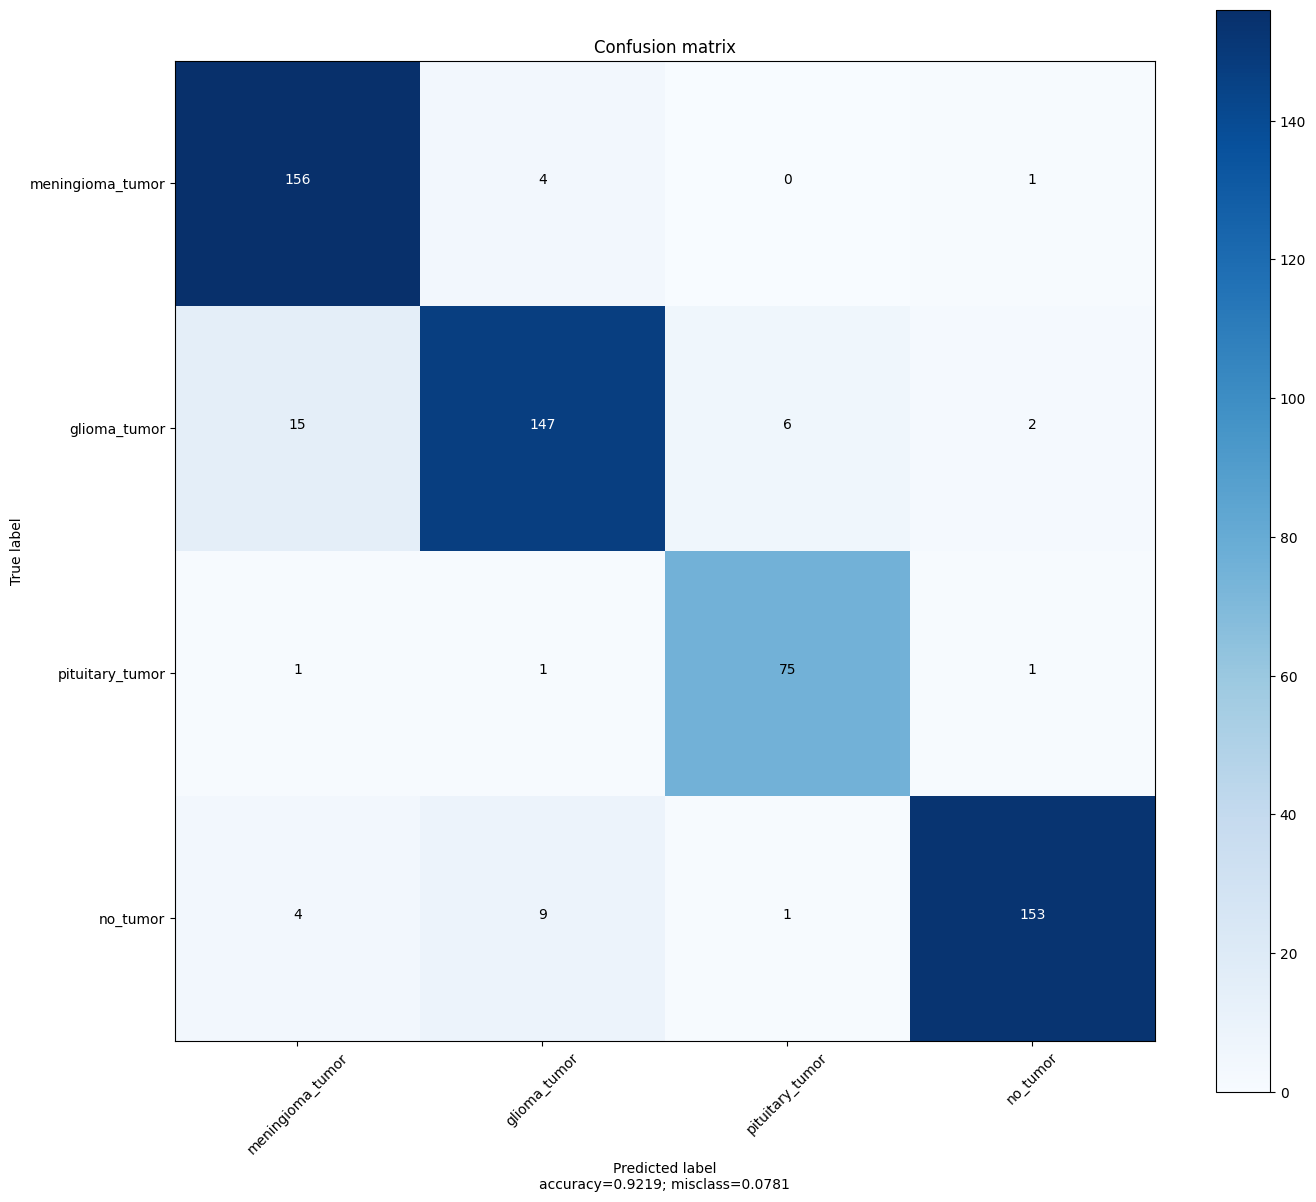

The Accuracy : 92.1875
The Precision : 92.21408884898999
The Recall : 92.78390269852359
The F1 Score : 92.39944977104817


In [ ]:
from sklearn import metrics
# from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= class_names_train, title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")